In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random
from datetime import datetime
import pytz

# importo los .py
import sys
sys.path.append("auxiliares")
import config
import metricas
import lightgbm_aux
import extras

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
arch_entrada = "datasets/emp3_sellout_producto_fe.csv"
carpeta_exp_prefijo = "exp/intermedia_1/"

In [4]:
def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = metricas.error_rate(labels,preds)
    return 'ER', ret_val, False

In [5]:
def objective(trial):
    print("****************", config.OBJECTIVE_PARAM, "****************")
    
    lgb_params = {
        'objective': config.OBJECTIVE_PARAM,
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0,config.L1_UPPER_PARAM),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0,config.L2_UPPER_PARAM),
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': config.MAX_BIN_PARAM,
        'learning_rate': trial.suggest_uniform('learning_rate', config.LEARNING_RATE_LOWER_PARAM,config.LEARNING_RATE_UPPER_PARAM ),
        'num_leaves' : trial.suggest_int('num_leaves', config.NUM_LEAVES_LOWER_PARAM, config.NUM_LEAVES_UPPER_PARAM),
        'feature_fraction': trial.suggest_uniform('feature_fraction', config.FEATURE_FRACTION_LOWER_PARAM, config.FEATURE_FRACTION_UPPER_PARAM),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', config.MIN_DATA_IN_LEAF_LOWER_PARAM, config.MIN_DATA_IN_LEAF_UPPER_PARAM),
        #'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        #'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        #'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols_entren)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols_entren)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = metricas.error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [6]:
##############################################

In [7]:
df_sellout = pd.read_csv(arch_entrada)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 34707 non-null  int64  
 1   periodo                    34707 non-null  int64  
 2   tn                         34707 non-null  float64
 3   cero_ventas                34707 non-null  int64  
 4   cust_request_qty           34707 non-null  float64
 5   cust_request_tn            34707 non-null  float64
 6   mes                        34707 non-null  int64  
 7   producto_estrella          34707 non-null  float64
 8   plan_precios_cuidados      34707 non-null  float64
 9   meses_historia_prod        34707 non-null  int64  
 10  cat1                       34707 non-null  object 
 11  cat2                       34707 non-null  object 
 12  cat3                       34707 non-null  object 
 13  sku_size                   34707 non-null  flo

In [8]:
df_prods_prediccion_entren=pd.read_csv(config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO)
df_prods_prediccion_entren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   product_id  868 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


In [9]:
### Categoricas
df_sellout = extras.convertir_categoricas_prod(df_sellout)

In [10]:
### Split de datasets
df_train = df_sellout[(df_sellout.periodo <= config.TRAIN_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_validate = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion_entren.product_id)) & (df_sellout.periodo == config.VALIDATE_PERIODO_PARAM)]

print("Periodos entrenar:",df_train.periodo.unique())
print("Periodos validar:",df_validate.periodo.unique())

df_validate = df_validate.sort_values(by="product_id",ascending=True)
print("product_id a validar:", len(df_validate))

Periodos entrenar: [201706 201707 201708 201709 201710 201711 201712 201801 201802 201803
 201804 201805 201806 201807 201808 201809 201810]
Periodos validar: [201812]
product_id a validar: 868


In [11]:
### Armado variables entrenamiento
cols_remover_entren = ["tn_mas_2","periodo"]

# Train - Validate
X_train = df_train.drop(columns=cols_remover_entren, axis=1)
X_validate = df_validate.drop(columns=cols_remover_entren, axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

cols_entren = X_train.columns.tolist()

X_train: (16005, 26)
y_train: (16005,)

X_validate: (868, 26)
y_validate: (868,)


In [12]:
### Optimizacion Bayesiana
GLOBAL_PARAMS_ITER = []
GLOBAL_BEST_IT_ITER = []
GLOBAL_ER_VALIDATE_ITER = []
GLOBAL_MODEL_ITER = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=config.CANT_ITERACIONES_OPT_BAY_PARAM)
print('# Experimentos:', len(study.trials))
print('Mejor experimento:', study.best_trial.params)

[I 2023-12-18 18:29:45,245] A new study created in memory with name: no-name-c9b756a9-7c08-401e-b700-fd997b34fc28


**************** regression ****************
Training until validation scores don't improve for 86 rounds
[100]	valid_0's ER: 79.78


[I 2023-12-18 18:29:45,508] Trial 0 finished with value: 79.65 and parameters: {'lambda_l1': 249.75891956784625, 'lambda_l2': 172.58493830592013, 'learning_rate': 0.13573690962856688, 'num_leaves': 736, 'feature_fraction': 0.9234283338576366, 'min_data_in_leaf': 6913}. Best is trial 0 with value: 79.65.


Early stopping, best iteration is:
[102]	valid_0's ER: 79.65
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 75 rounds


[I 2023-12-18 18:29:45,692] Trial 1 finished with value: 78.51 and parameters: {'lambda_l1': 534.9805378631576, 'lambda_l2': 446.93991416469794, 'learning_rate': 0.19741310806044388, 'num_leaves': 619, 'feature_fraction': 0.9667235854105398, 'min_data_in_leaf': 6664}. Best is trial 1 with value: 78.51.


[100]	valid_0's ER: 78.98
Early stopping, best iteration is:
[75]	valid_0's ER: 78.51
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 124 rounds
[100]	valid_0's ER: 67.31
[200]	valid_0's ER: 61.87
[300]	valid_0's ER: 58.53
[400]	valid_0's ER: 56.44
[500]	valid_0's ER: 55.14
[600]	valid_0's ER: 54.17
[700]	valid_0's ER: 53.95
[800]	valid_0's ER: 53.41
[900]	valid_0's ER: 53.04
[1000]	valid_0's ER: 52.73
[1100]	valid_0's ER: 52.53
[1200]	valid_0's ER: 52.26
[1300]	valid_0's ER: 52.25


[I 2023-12-18 18:29:47,301] Trial 2 finished with value: 52.2 and parameters: {'lambda_l1': 610.0608536533429, 'lambda_l2': 999.1423977576756, 'learning_rate': 0.0671529883019494, 'num_leaves': 698, 'feature_fraction': 0.9110165540161137, 'min_data_in_leaf': 4414}. Best is trial 2 with value: 52.2.


Early stopping, best iteration is:
[1269]	valid_0's ER: 52.2
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 74 rounds


[I 2023-12-18 18:29:47,627] Trial 3 finished with value: 42.88 and parameters: {'lambda_l1': 469.02942839427664, 'lambda_l2': 796.5865540937199, 'learning_rate': 0.20286298354307206, 'num_leaves': 243, 'feature_fraction': 0.559180581524823, 'min_data_in_leaf': 1700}. Best is trial 3 with value: 42.88.


[100]	valid_0's ER: 43.57
[200]	valid_0's ER: 44.52
Early stopping, best iteration is:
[136]	valid_0's ER: 42.88
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 68 rounds


[I 2023-12-18 18:29:47,768] Trial 4 finished with value: 76.84 and parameters: {'lambda_l1': 729.6050339740099, 'lambda_l2': 276.3973997911566, 'learning_rate': 0.26852034332344155, 'num_leaves': 676, 'feature_fraction': 0.5746039945433359, 'min_data_in_leaf': 6245}. Best is trial 3 with value: 42.88.


[100]	valid_0's ER: 77.48
Early stopping, best iteration is:
[41]	valid_0's ER: 76.84
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 98 rounds
[100]	valid_0's ER: 78.02
[200]	valid_0's ER: 77.4


[I 2023-12-18 18:29:48,019] Trial 5 finished with value: 77.12 and parameters: {'lambda_l1': 184.52515474762586, 'lambda_l2': 224.32867853610017, 'learning_rate': 0.10288555567846625, 'num_leaves': 744, 'feature_fraction': 0.20377469209842483, 'min_data_in_leaf': 6242}. Best is trial 3 with value: 42.88.


Early stopping, best iteration is:
[174]	valid_0's ER: 77.12
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 134 rounds
[100]	valid_0's ER: 75.49


[I 2023-12-18 18:29:48,264] Trial 6 finished with value: 75.31 and parameters: {'lambda_l1': 821.494156049905, 'lambda_l2': 750.6957726735221, 'learning_rate': 0.05892673482565304, 'num_leaves': 163, 'feature_fraction': 0.9283171616402182, 'min_data_in_leaf': 5849}. Best is trial 3 with value: 42.88.


[200]	valid_0's ER: 75.58
Early stopping, best iteration is:
[91]	valid_0's ER: 75.31
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 73 rounds
[100]	valid_0's ER: 68.26
[200]	valid_0's ER: 65.4
[300]	valid_0's ER: 64.61
[400]	valid_0's ER: 63.97


[I 2023-12-18 18:29:48,913] Trial 7 finished with value: 62.41 and parameters: {'lambda_l1': 35.20069825942185, 'lambda_l2': 262.94413984175037, 'learning_rate': 0.21550781457796825, 'num_leaves': 202, 'feature_fraction': 0.3179921844345221, 'min_data_in_leaf': 4734}. Best is trial 3 with value: 42.88.


[500]	valid_0's ER: 63.18
[600]	valid_0's ER: 62.69
Early stopping, best iteration is:
[625]	valid_0's ER: 62.41
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 88 rounds
[100]	valid_0's ER: 80.57
[200]	valid_0's ER: 80.51
Early stopping, best iteration is:
[163]	valid_0's ER: 80.05
Evaluated only: ER


[I 2023-12-18 18:29:49,170] Trial 8 finished with value: 80.05 and parameters: {'lambda_l1': 62.0160165111987, 'lambda_l2': 462.6566105831984, 'learning_rate': 0.13142014076622938, 'num_leaves': 903, 'feature_fraction': 0.3272381084591326, 'min_data_in_leaf': 7082}. Best is trial 3 with value: 42.88.
[I 2023-12-18 18:29:49,335] Trial 9 finished with value: 75.18 and parameters: {'lambda_l1': 188.48199746861027, 'lambda_l2': 702.8571407492761, 'learning_rate': 0.1593182815734364, 'num_leaves': 655, 'feature_fraction': 0.9538648002470014, 'min_data_in_leaf': 5804}. Best is trial 3 with value: 42.88.


**************** regression ****************
Training until validation scores don't improve for 81 rounds
[100]	valid_0's ER: 75.42
Early stopping, best iteration is:
[53]	valid_0's ER: 75.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 67 rounds
[100]	valid_0's ER: 39.01


[I 2023-12-18 18:29:49,809] Trial 10 finished with value: 36.98 and parameters: {'lambda_l1': 974.5802801696666, 'lambda_l2': 976.9745702264263, 'learning_rate': 0.2855640750984137, 'num_leaves': 304, 'feature_fraction': 0.6491370663287163, 'min_data_in_leaf': 1142}. Best is trial 10 with value: 36.98.


[200]	valid_0's ER: 37.23
Early stopping, best iteration is:
[202]	valid_0's ER: 36.98
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 66 rounds


[I 2023-12-18 18:29:50,102] Trial 11 finished with value: 36.21 and parameters: {'lambda_l1': 945.784903174294, 'lambda_l2': 993.1511362957939, 'learning_rate': 0.29577860929481176, 'num_leaves': 318, 'feature_fraction': 0.6366816720848728, 'min_data_in_leaf': 882}. Best is trial 11 with value: 36.21.


[100]	valid_0's ER: 36.52
Early stopping, best iteration is:
[75]	valid_0's ER: 36.21
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 66 rounds
[100]	valid_0's ER: 28.72
[200]	valid_0's ER: 26.81
[300]	valid_0's ER: 26.34
[400]	valid_0's ER: 26.05


[I 2023-12-18 18:29:51,429] Trial 12 finished with value: 25.94 and parameters: {'lambda_l1': 994.9891503038601, 'lambda_l2': 986.3582755933404, 'learning_rate': 0.2973283652017673, 'num_leaves': 365, 'feature_fraction': 0.7319809176874111, 'min_data_in_leaf': 216}. Best is trial 12 with value: 25.94.


Early stopping, best iteration is:
[426]	valid_0's ER: 25.94
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 66 rounds
[100]	valid_0's ER: 27.33
[200]	valid_0's ER: 25.42
[300]	valid_0's ER: 24.73
[400]	valid_0's ER: 24.29
[500]	valid_0's ER: 24.14
Early stopping, best iteration is:
[507]	valid_0's ER: 24.09
Evaluated only: ER


[I 2023-12-18 18:29:53,131] Trial 13 finished with value: 24.09 and parameters: {'lambda_l1': 979.5358812767505, 'lambda_l2': 879.3539852146537, 'learning_rate': 0.2966669934131415, 'num_leaves': 449, 'feature_fraction': 0.7157043944926237, 'min_data_in_leaf': 45}. Best is trial 13 with value: 24.09.


**************** regression ****************
Training until validation scores don't improve for 69 rounds


[I 2023-12-18 18:29:53,646] Trial 14 finished with value: 25.49 and parameters: {'lambda_l1': 986.2890076780225, 'lambda_l2': 22.207805866709236, 'learning_rate': 0.2518765230387419, 'num_leaves': 390, 'feature_fraction': 0.7610540307706827, 'min_data_in_leaf': 8}. Best is trial 13 with value: 24.09.


[100]	valid_0's ER: 25.61
Early stopping, best iteration is:
[105]	valid_0's ER: 25.49
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 69 rounds


[I 2023-12-18 18:29:53,915] Trial 15 finished with value: 52.2 and parameters: {'lambda_l1': 836.1824352460416, 'lambda_l2': 22.98797599852001, 'learning_rate': 0.25018034582611126, 'num_leaves': 453, 'feature_fraction': 0.7896744580291462, 'min_data_in_leaf': 2664}. Best is trial 13 with value: 24.09.


[100]	valid_0's ER: 52.36
Early stopping, best iteration is:
[87]	valid_0's ER: 52.2
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 70 rounds
[100]	valid_0's ER: 52.48
[200]	valid_0's ER: 50.97


[I 2023-12-18 18:29:54,377] Trial 16 finished with value: 50.36 and parameters: {'lambda_l1': 831.3594728428882, 'lambda_l2': 0.3678541362481518, 'learning_rate': 0.24259979262060868, 'num_leaves': 48, 'feature_fraction': 0.8086875325808633, 'min_data_in_leaf': 2771}. Best is trial 13 with value: 24.09.


[300]	valid_0's ER: 50.82
Early stopping, best iteration is:
[258]	valid_0's ER: 50.36
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 69 rounds


[I 2023-12-18 18:29:54,731] Trial 17 finished with value: 49.63 and parameters: {'lambda_l1': 701.9445787257987, 'lambda_l2': 610.256281884971, 'learning_rate': 0.2511339985928691, 'num_leaves': 476, 'feature_fraction': 0.7216234386264697, 'min_data_in_leaf': 2445}. Best is trial 13 with value: 24.09.


[100]	valid_0's ER: 51.03
[200]	valid_0's ER: 49.88
Early stopping, best iteration is:
[153]	valid_0's ER: 49.63
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 72 rounds
[100]	valid_0's ER: 28.98
[200]	valid_0's ER: 26.5
[300]	valid_0's ER: 25.68
[400]	valid_0's ER: 25.13


[I 2023-12-18 18:29:56,043] Trial 18 finished with value: 25.05 and parameters: {'lambda_l1': 883.7881637271421, 'lambda_l2': 555.4768876576236, 'learning_rate': 0.2271281509926315, 'num_leaves': 539, 'feature_fraction': 0.514303318506854, 'min_data_in_leaf': 147}. Best is trial 13 with value: 24.09.


[500]	valid_0's ER: 25.13
Early stopping, best iteration is:
[431]	valid_0's ER: 25.05
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 72 rounds
[100]	valid_0's ER: 56.61
[200]	valid_0's ER: 53.69
[300]	valid_0's ER: 52.46
[400]	valid_0's ER: 51.64


[I 2023-12-18 18:29:56,764] Trial 19 finished with value: 50.96 and parameters: {'lambda_l1': 888.9669599609233, 'lambda_l2': 852.3700540975248, 'learning_rate': 0.22437278521536408, 'num_leaves': 562, 'feature_fraction': 0.5282551205607696, 'min_data_in_leaf': 3271}. Best is trial 13 with value: 24.09.


[500]	valid_0's ER: 51.08
Early stopping, best iteration is:
[518]	valid_0's ER: 50.96
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 463 rounds
[100]	valid_0's ER: 60.11
[200]	valid_0's ER: 52.52
[300]	valid_0's ER: 52.82
[400]	valid_0's ER: 53.08
[500]	valid_0's ER: 52.82
[600]	valid_0's ER: 52.15
[700]	valid_0's ER: 51.34
[800]	valid_0's ER: 50.62
[900]	valid_0's ER: 49.93
[1000]	valid_0's ER: 49.04
[1100]	valid_0's ER: 48.17
[1200]	valid_0's ER: 47.41
[1300]	valid_0's ER: 46.75
[1400]	valid_0's ER: 46.27
[1500]	valid_0's ER: 45.89
[1600]	valid_0's ER: 45.61
[1700]	valid_0's ER: 45.33
[1800]	valid_0's ER: 45.17
[1900]	valid_0's ER: 45.1
[2000]	valid_0's ER: 45.02
[2100]	valid_0's ER: 44.92
[2200]	valid_0's ER: 44.77
[2300]	valid_0's ER: 44.7
[2400]	valid_0's ER: 44.61
[2500]	valid_0's ER: 44.46
[2600]	valid_0's ER: 44.32
[2700]	valid_0's ER: 44.42
[2800]	valid_0's ER: 44.17
[2900]	valid_0's ER: 44.17
[3000]	valid_0'

[I 2023-12-18 18:30:01,625] Trial 20 finished with value: 44.08 and parameters: {'lambda_l1': 726.4715165179591, 'lambda_l2': 596.812246949449, 'learning_rate': 0.01207868709274873, 'num_leaves': 855, 'feature_fraction': 0.48595914219764513, 'min_data_in_leaf': 1722}. Best is trial 13 with value: 24.09.


Early stopping, best iteration is:
[3012]	valid_0's ER: 44.08
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 68 rounds
[100]	valid_0's ER: 27.63
[200]	valid_0's ER: 26.46
[300]	valid_0's ER: 26.03
Early stopping, best iteration is:
[303]	valid_0's ER: 26.02
Evaluated only: ER


[I 2023-12-18 18:30:02,739] Trial 21 finished with value: 26.02 and parameters: {'lambda_l1': 988.814541803711, 'lambda_l2': 409.45844232445455, 'learning_rate': 0.268893462774724, 'num_leaves': 415, 'feature_fraction': 0.6832223651779545, 'min_data_in_leaf': 88}. Best is trial 13 with value: 24.09.


**************** regression ****************
Training until validation scores don't improve for 68 rounds
[100]	valid_0's ER: 35.2
[200]	valid_0's ER: 34.35


[I 2023-12-18 18:30:03,299] Trial 22 finished with value: 34.2 and parameters: {'lambda_l1': 882.3483477799538, 'lambda_l2': 571.4697482016018, 'learning_rate': 0.270367365552076, 'num_leaves': 530, 'feature_fraction': 0.8484501743242241, 'min_data_in_leaf': 819}. Best is trial 13 with value: 24.09.


Early stopping, best iteration is:
[219]	valid_0's ER: 34.2
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 71 rounds
[100]	valid_0's ER: 30.24
[200]	valid_0's ER: 28.59
[300]	valid_0's ER: 27.76
[400]	valid_0's ER: 27.29
[500]	valid_0's ER: 27.06
[600]	valid_0's ER: 26.79
[700]	valid_0's ER: 26.76


[I 2023-12-18 18:30:05,696] Trial 23 finished with value: 26.64 and parameters: {'lambda_l1': 910.2821910353234, 'lambda_l2': 687.7116585418282, 'learning_rate': 0.22877839336968697, 'num_leaves': 1021, 'feature_fraction': 0.7468899043861784, 'min_data_in_leaf': 13}. Best is trial 13 with value: 24.09.


[800]	valid_0's ER: 26.7
Early stopping, best iteration is:
[756]	valid_0's ER: 26.64
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 76 rounds


[I 2023-12-18 18:30:06,096] Trial 24 finished with value: 44.41 and parameters: {'lambda_l1': 991.804284899801, 'lambda_l2': 400.9830226836589, 'learning_rate': 0.18965099018487078, 'num_leaves': 550, 'feature_fraction': 0.6090110875374843, 'min_data_in_leaf': 1658}. Best is trial 13 with value: 24.09.


[100]	valid_0's ER: 45.34
[200]	valid_0's ER: 44.61
Early stopping, best iteration is:
[154]	valid_0's ER: 44.41
Evaluated only: ER
# Experimentos: 25
Mejor experimento: {'lambda_l1': 979.5358812767505, 'lambda_l2': 879.3539852146537, 'learning_rate': 0.2966669934131415, 'num_leaves': 449, 'feature_fraction': 0.7157043944926237, 'min_data_in_leaf': 45}


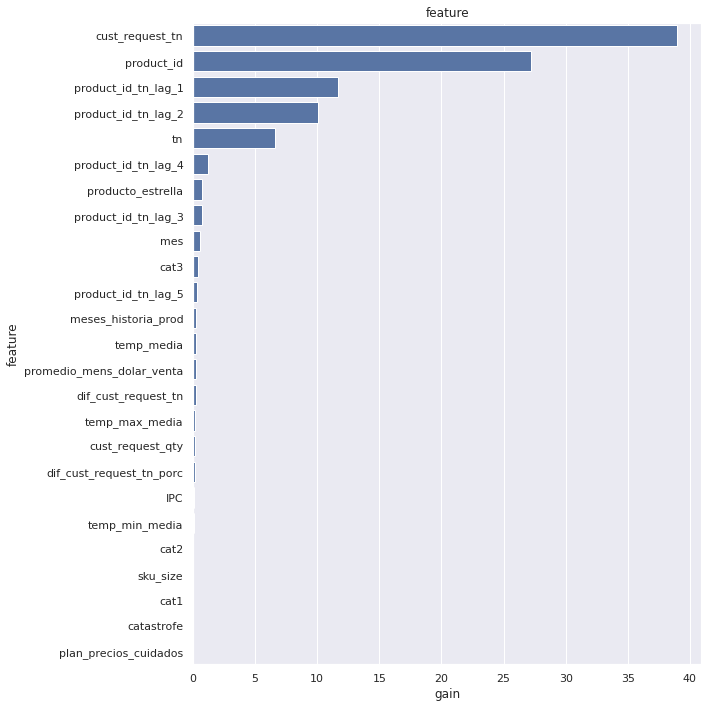

In [13]:
# Feature Importance
best_model_index = study.best_trial.number
best_model = GLOBAL_MODEL_ITER[best_model_index]
feature_importance = lightgbm_aux.plot_lgb_importances(best_model, num=30, plot=True)

In [14]:
#Si se usa holdout, se generan variables para luego evaluar modelos
if(config.USAR_HOLDOUT_PARAM):
    # Dataframes
    df_train_all = df_sellout[(df_sellout.periodo <= config.TRAIN_ALL_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
    df_holdout = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion_entren.product_id)) & (df_sellout.periodo == config.HOLDOUT_PERIODO_PARAM)]
    
    df_holdout = df_holdout.sort_values(by="product_id",ascending=True)
    print("product_id a testear:", len(df_holdout))

    print("Periodos entrenar ALL:",df_train_all.periodo.unique())
    print("Periodos holdout:",df_holdout.periodo.unique())

    # Variables entrenamiento
    X_train_all = df_train_all.drop(columns=cols_remover_entren, axis=1)
    X_holdout = df_holdout.drop(columns=cols_remover_entren, axis=1)
    
    y_train_all = df_train_all.tn_mas_2
    y_holdout = df_holdout.tn_mas_2
    print("\nX_train_all:", X_train_all.shape)
    print("y_train_all:", y_train_all.shape)
    
    print("\nX_holdout:", X_holdout.shape)
    print("y_holdout:", y_holdout.shape)

    lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols_entren)

product_id a testear: 868
Periodos entrenar ALL: [201706 201707 201708 201709 201710 201711 201712 201801 201802 201803
 201804 201805 201806 201807 201808 201809 201810 201811 201812]
Periodos holdout: [201902]

X_train_all: (18107, 26)
y_train_all: (18107,)

X_holdout: (868, 26)
y_holdout: (868,)


In [15]:
current_datetime = datetime.now().astimezone(pytz.timezone('America/Argentina/Buenos_Aires'))
exp_numero = current_datetime.strftime("%Y%m%d %H%M%S").replace(" ", "_")
exp_numero

'20231218_153006'

In [16]:
# Guardo resultados
carpeta_exp = carpeta_exp_prefijo + exp_numero + "/"
if not os.path.exists(carpeta_exp):
    os.makedirs(carpeta_exp)
    
# Feature Importance
feature_importance.to_csv(carpeta_exp + "feature_importance.csv",index=False)

# Parametros
parametros_nombres = ["PERIODOS_EXCLUIR","PERIODO_INICIO_PARAM","TRAIN_PERIODO_LIMITE_PARAM",
                      "VALIDATE_PERIODO_PARAM","USAR_HOLDOUT_PARAM",
                      "TRAIN_ALL_PERIODO_LIMITE_PARAM","HOLDOUT_PERIODO_PARAM",
                      "MODELO_FINAL_PERIODO_LIMITE_PARAM","FUTURE_PERIODO_PARAM",
                      "ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO","ARCH_PRODUCTOS_PREDICCION_FUTURE",
                      "NUM_LAGS_PARAM","FAMILIA_FEATURES_TEMP_PARAM","AMPLIA_FEATURES_PARAM",
                      "CANT_ITERACIONES_OPT_BAY_PARAM","CANT_SEMILLAS"]

parametros_valores = [config.PERIODOS_EXCLUIR,config.PERIODO_INICIO_PARAM,config.TRAIN_PERIODO_LIMITE_PARAM,
                      config.VALIDATE_PERIODO_PARAM,
                      config.USAR_HOLDOUT_PARAM,config.TRAIN_ALL_PERIODO_LIMITE_PARAM,config.HOLDOUT_PERIODO_PARAM,
                      config.MODELO_FINAL_PERIODO_LIMITE_PARAM,config.FUTURE_PERIODO_PARAM,
                      config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO,config.ARCH_PRODUCTOS_PREDICCION_FUTURE,
                      config.NUM_LAGS_PARAM,config.FAMILIA_FEATURES_TEMP_PARAM,config.AMPLIA_FEATURES_PARAM,
                      config.CANT_ITERACIONES_OPT_BAY_PARAM, config.CANT_SEMILLAS]

parametros = pd.DataFrame(data={"nombre":parametros_nombres,"valor":parametros_valores})
parametros.to_csv(carpeta_exp + "parametros.csv",index=False)

# Optimizacion Bayesiana
df_opt_bay = pd.DataFrame(data={"lgb_params":GLOBAL_PARAMS_ITER,"best_iteration":GLOBAL_BEST_IT_ITER,
                                "error_rate_validate":GLOBAL_ER_VALIDATE_ITER})

# Ordeno de menor a mayor
df_opt_bay = df_opt_bay.sort_values(by="error_rate_validate",ascending=True)
df_opt_bay["index"] = range(0,len(GLOBAL_PARAMS_ITER))

# Holdout
if(config.USAR_HOLDOUT_PARAM):
    er_holdout_iter = [None] * len(df_opt_bay)
    er_holdout_semillerio_iter = [None] * len(df_opt_bay)
    
    for i in range(config.OFFSET_EVAL_HOLDOUT,config.CANT_EVAL_HOLDOUT):
        print("Iteración:",i)

        #Modelo Train All (Sin Semillerio)
        model_train_all = lgb.train(df_opt_bay.iloc[i].lgb_params, lgbtrain_all, num_boost_round=df_opt_bay.iloc[i].best_iteration)
        y_pred_holdout = model_train_all.predict(X_holdout)
        er_holdout = metricas.error_rate(y_holdout,y_pred_holdout)
        er_holdout_iter[i]=er_holdout
        
        #Semillerio
        y_pred_holdout_semillerio = lightgbm_aux.semillerio(lgbtrain_all, df_opt_bay.iloc[i].lgb_params, df_opt_bay.iloc[i].best_iteration, X_holdout,config.CANT_SEMILLAS)
        er_holdout_semillerio_iter[i]= metricas.error_rate(y_holdout,y_pred_holdout_semillerio)
        
    df_opt_bay["error_rate_holdout"]=er_holdout_iter    
    df_opt_bay["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    

df_opt_bay.to_excel(carpeta_exp +  "opt_bay.xlsx",index=False)

Iteración: 0
Iteración: 1
Iteración: 2
Iteración: 3
Iteración: 4


In [17]:
print("FINALIZADO")
exp_numero

FINALIZADO


'20231218_153006'